This notebook contains BDT variables' distribution from major background

In [1]:
from coffea import hist
from coffea.analysis_objects import JaggedCandidateArray
from coffea.processor import defaultdict_accumulator
import coffea.processor as processor
import uproot

import numpy as np
import matplotlib.pyplot as plt
from FireHydrant.Tools.uproothelpers import NestNestObjArrayToJagged

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [24]:
import json
datasets_=json.load(open('../Samples/backgrounds_nonempty.json'))
scales_=json.load(open('../Samples/backgrounds_scale.json'))

# flatten datasets
datasets = {}
for group in datasets_:
    for tag in datasets_[group]:
        files = datasets_[group][tag]
        datasets[tag] = {'files': files, 'treename': 'ffNtuples/ffNtuple'}

# flatten scales
scales = {}
for group in scales_:
    for tag in scales_[group]:
        scales[tag] = scales_[group][tag]

lumi = 60.432*1e3
for k in scales:
    scales[k] *= lumi

# mapping
mapping = {}
for k in datasets_: mapping[k] = list(datasets_[k])

### Let's plot all leptonJets pT (and multiplicity) first

In [3]:
class LeptonJetProcessor(processor.ProcessorABC):
    def __init__(self):
        dataset_axis = hist.Cat('dataset', 'backgrounds')
        multiplicity_axis = hist.Bin("multiplicity", "#leptonJets/event", 10, 0, 10)
        pt_axis = hist.Bin("pt", "$p_T$[GeV]", 50, 0, 800)
        
        self._accumulator = processor.dict_accumulator({
            'multi': hist.Hist("Counts", dataset_axis, multiplicity_axis),
            "pt": hist.Hist("#counts/16GeV", dataset_axis, pt_axis)
        })
    
    @property
    def accumulator(self):
        return self._accumulator
    
    def process(self, df):
        output = self.accumulator.identity()
        
        dataset = df['dataset']
        leptonjets = JaggedCandidateArray.candidatesfromcounts(
            df['pfjet_p4'],
            px=df['pfjet_p4.fCoordinates.fX'],
            py=df['pfjet_p4.fCoordinates.fY'],
            pz=df['pfjet_p4.fCoordinates.fZ'],
            energy=df['pfjet_p4.fCoordinates.fT'],
        )
        twoleptonjets = leptonjets.counts>=2
        dileptonjets = leptonjets[twoleptonjets]
        leptonjetpair = dileptonjets.distincts()
        sumpt = leptonjetpair.i0.pt+leptonjetpair.i1.pt
        if sumpt.size!=0:
            leadingLjPair = leptonjetpair[sumpt.argmax()]
            controlregion = np.abs(leadingLjPair.i0.p4.delta_phi(leadingLjPair.i1.p4))<2.5
            leptonjets_ = dileptonjets[controlregion.flatten()]
        else:
            leptonjets_ = dileptonjets
        
        output['multi'].fill(dataset=dataset, multiplicity=leptonjets_.counts)
        output['pt'].fill(dataset=dataset, pt=leptonjets_.pt.flatten())
        
        return output
    
    def postprocess(self, accumulator):
        # scale
        accumulator['multi'].scale(scales, axis='dataset')
        accumulator['pt'].scale(scales, axis='dataset')
        # cat grouping
        accumulator['multi_cat'] = accumulator['multi'].group(hist.Cat("cat", "datasets"), "dataset", mapping)
        accumulator['pt_cat'] = accumulator['pt'].group(hist.Cat("cat", "datasets"), "dataset", mapping)
        
        return accumulator

In [5]:
output = processor.run_uproot_job(datasets,
                                  treename=None,
                                  processor_instance=LeptonJetProcessor(),
                                  executor=processor.futures_executor,
                                  executor_args=dict(workers=12, flatten=True),
                                  chunksize=500000,
                                 )

Processing: 100%|██████████| 2753/2753 [02:02<00:00, 22.52items/s]


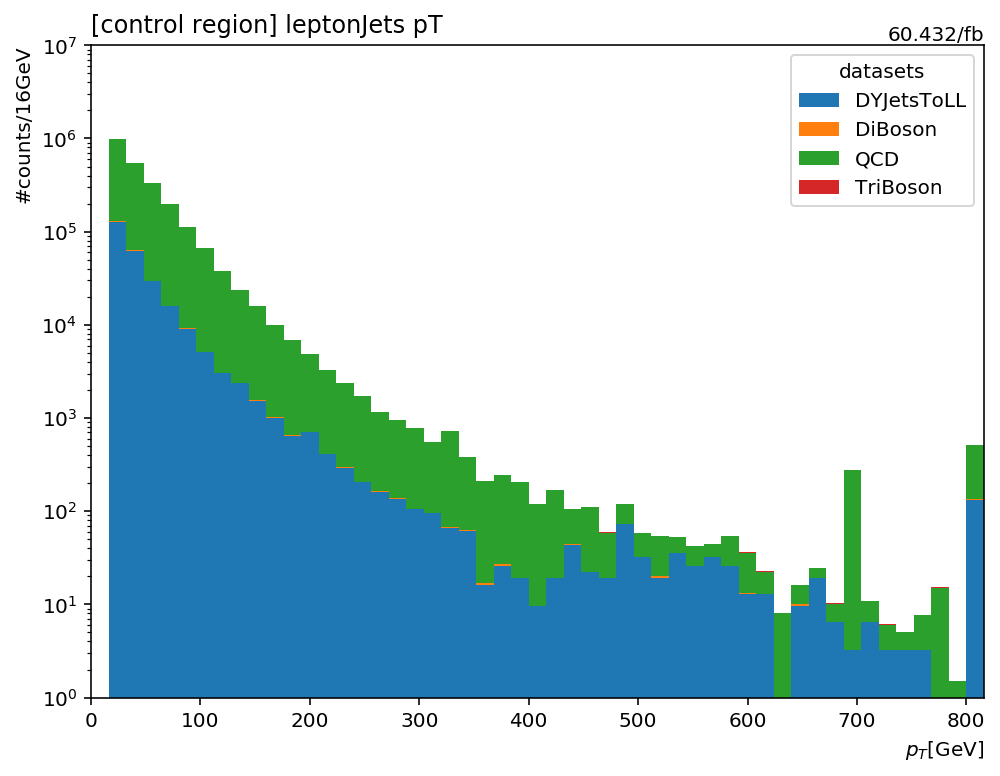

In [7]:
fig, ax = plt.subplots(figsize=(8,6))
fig, ax, _ = hist.plot1d(output['pt_cat'], overlay='cat', stack=True, ax=ax, overflow='over')
ax.set_yscale('log')
ax.set_ylim([1, 1e7])
ax.text(1,1,'60.432/fb', ha='right', va='bottom', transform=ax.transAxes)
ax.set_title('[control region] leptonJets pT', x=0.0, ha="left")
ax.set_xlabel(ax.get_xlabel(), x=1.0, ha="right")
ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right");

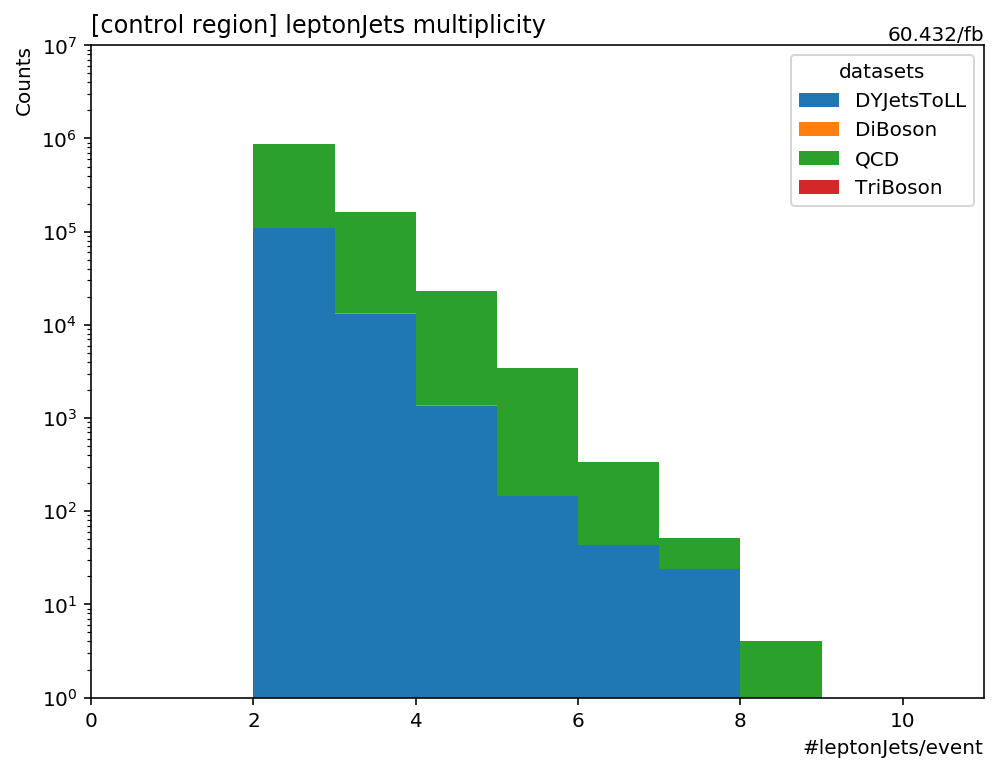

In [10]:
fig, ax = plt.subplots(figsize=(8,6))
fig, ax, _ = hist.plot1d(output['multi_cat'], overlay='cat', stack=True, ax=ax, overflow='over')
ax.set_yscale('log')
ax.set_ylim([1, 1e7])
ax.text(1,1,'60.432/fb', ha='right', va='bottom', transform=ax.transAxes)
ax.set_title('[control region] leptonJets multiplicity', x=0.0, ha="left")
ax.set_xlabel(ax.get_xlabel(), x=1.0, ha="right")
ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right");

## Variables as input for BDT
- leptonJet pT, eta
- neutral energy fraction
- maxd0, mind0
- tkiso, pfiso
- spreadpt, spreaddr
- lambda, epsilon
- ecf 1,2,3

and
- BDT score

In [22]:
class LeptonJetsProcessor(processor.ProcessorABC):
    def __init__(self):
        dataset_axis = hist.Cat('dataset', 'Control region')
        pt_axis       = hist.Bin("pt", "pT [GeV]", 50, 0, 800)
        eta_axis      = hist.Bin("eta", 'eta', 50, -2.4, 2.4)
        nef_axis      = hist.Bin("nef", "neutral energy fraction", 50, 0, 1)
        maxd0_axis    = hist.Bin("maxd0", 'track max |d0|', 50, 0, 0.5)
        mind0_axis    = hist.Bin("mind0", 'track min |d0|', 50, 0, 0.5)
        tkiso_axis    = hist.Bin('tkiso', 'track isolation', 50, 0, 1)
        pfiso_axis    = hist.Bin("pfiso", "PFCands isolation", 50, 0, 1)
        spreadpt_axis = hist.Bin("spreadpt", "spreadpt", 50, 0, 1)
        spreaddr_axis = hist.Bin("spreaddr", "spreaddr", 50, 0, 0.1)
        lambda_axis   = hist.Bin('lamb', 'jet sub - lambda', 50, -8, 0)
        epsilon_axis  = hist.Bin('epsi', 'jet sub - epsilon', 50, 0, 0.25)
        ecfe1_axis    = hist.Bin('ecfe1', 'energy correlation function - e1', 50, 0, 200)
        ecfe2_axis    = hist.Bin('ecfe2', 'energy correlation function - e2', 50, 0, 500)
        ecfe3_axis    = hist.Bin('ecfe3', 'energy correlation function - e3', 50, 0, 300)
        mva_axis      = hist.Bin('mva', 'BDT value', 50, -10, 10)
        
        self._accumulator = processor.dict_accumulator({
            'pt': hist.Hist("#counts/16GeV", dataset_axis, pt_axis),
            "eta": hist.Hist("#counts/0.096", dataset_axis, eta_axis),
            "nef": hist.Hist("#counts/0.02", dataset_axis, nef_axis),
            "maxd0": hist.Hist("#counts/0.01cm", dataset_axis, maxd0_axis),
            "mind0": hist.Hist("#counts/0.01cm", dataset_axis, mind0_axis),
            "tkiso": hist.Hist("#counts/0.02", dataset_axis, tkiso_axis),
            "pfiso": hist.Hist("#counts/0.02", dataset_axis, pfiso_axis),
            "spreadpt": hist.Hist("#counts/0.02", dataset_axis, spreadpt_axis),
            "spreaddr": hist.Hist("#counts/0.002", dataset_axis, spreaddr_axis),
            "lamb": hist.Hist("#counts/0.16", dataset_axis, lambda_axis),
            "epsi": hist.Hist("#counts/0.005", dataset_axis, epsilon_axis),
            "ecfe1": hist.Hist("#counts/4", dataset_axis, ecfe1_axis),
            "ecfe2": hist.Hist("#counts/10", dataset_axis, ecfe2_axis),
            "ecfe3": hist.Hist("#counts/6", dataset_axis, ecfe3_axis),
            "mva": hist.Hist("#counts/0.4", dataset_axis, mva_axis),
        })

    @property
    def accumulator(self):
        return self._accumulator
    
    def process(self, df):
        output = self.accumulator.identity()
        
        dataset = df['dataset']
        
        maxd0 = np.abs(NestNestObjArrayToJagged(df['pfjet_pfcand_tkD0'])).fillna(0).max()
        mind0 = np.abs(NestNestObjArrayToJagged(df['pfjet_pfcand_tkD0'])).fillna(0).min()
        
        leptonjets = JaggedCandidateArray.candidatesfromcounts(
            df['pfjet_p4'],
            px=df['pfjet_p4.fCoordinates.fX'],
            py=df['pfjet_p4.fCoordinates.fY'],
            pz=df['pfjet_p4.fCoordinates.fZ'],
            energy=df['pfjet_p4.fCoordinates.fT'],
            nef=(df['pfjet_neutralEmE']+df['pfjet_neutralHadronE'])/df['pfjet_p4.fCoordinates.fT'],
#             maxd0=JaggedArray.fromjagged(maxd0_),
#             mind0=JaggedArray.fromjagged(mind0_),
            tkiso=df['pfjet_tkIsolation05'],
            pfiso=df['pfjet_pfIsolation05'],
            spreadpt=df['pfjet_ptDistribution'],
            spreaddr=df['pfjet_dRSpread'],
            lamb=df['pfjet_subjet_lambda'],
            epsi=df['pfjet_subjet_epsilon'],
            ecf1=df['pfjet_subjet_ecf1'],
            ecf2=df['pfjet_subjet_ecf2'],
            ecf3=df['pfjet_subjet_ecf3'],
            mva=df['pfjet_mva'],
        )
        
        twoleptonjets = leptonjets.counts>=2
        dileptonjets = leptonjets[twoleptonjets]
        leptonjetpair = dileptonjets.distincts()
        dimaxd0 = maxd0[twoleptonjets]
        dimind0 = mind0[twoleptonjets]
        sumpt = leptonjetpair.i0.pt+leptonjetpair.i1.pt
        if sumpt.size!=0:
            leadingLjPair = leptonjetpair[sumpt.argmax()]
            controlregion = np.abs(leadingLjPair.i0.p4.delta_phi(leadingLjPair.i1.p4))<2.5
            leptonjets_ = dileptonjets[controlregion.flatten()]
            maxd0_ = dimaxd0[controlregion.flatten()]
            mind0_ = dimind0[controlregion.flatten()]
        else:
            leptonjets_ = dileptonjets
            maxd0_ = dimaxd0
            mind0_ = dimind0

        output['pt'].fill(dataset=dataset, pt=leptonjets_.pt.flatten())
        output['eta'].fill(dataset=dataset, eta=leptonjets_.eta.flatten())
        output['nef'].fill(dataset=dataset, nef=leptonjets_.nef.flatten())
        output['maxd0'].fill(dataset=dataset, maxd0=maxd0_.flatten())
        output['mind0'].fill(dataset=dataset, mind0=mind0_.flatten())
        output['tkiso'].fill(dataset=dataset, tkiso=leptonjets_.tkiso.flatten())
        output['pfiso'].fill(dataset=dataset, pfiso=leptonjets_.pfiso.flatten())
        output['spreadpt'].fill(dataset=dataset, spreadpt=leptonjets_.spreadpt.flatten())
        output['spreaddr'].fill(dataset=dataset, spreaddr=leptonjets_.spreaddr.flatten())
        output['lamb'].fill(dataset=dataset, lamb=leptonjets_.lamb.flatten())
        output['epsi'].fill(dataset=dataset, epsi=leptonjets_.epsi.flatten())
        output['ecfe1'].fill(dataset=dataset, ecfe1=leptonjets_.ecf1.flatten())
        output['ecfe2'].fill(dataset=dataset, ecfe2=leptonjets_.ecf2.flatten())
        output['ecfe3'].fill(dataset=dataset, ecfe3=leptonjets_.ecf3.flatten())
        output['mva'].fill(dataset=dataset, mva=leptonjets_.mva.flatten())
        
        return output
    
    def postprocess(self, accumulator):
        origidentity = list(accumulator)
        # scale
        for k in origidentity:
            accumulator[k].scale(scales, axis='dataset')
        # cat grouping
            accumulator[k+'_cat'] = accumulator[k].group(hist.Cat("cat", "datasets"), "dataset", mapping)
        return accumulator

In [25]:
output = processor.run_uproot_job(datasets,
                                  treename=None,
                                  processor_instance=LeptonJetsProcessor(),
                                  executor=processor.futures_executor,
                                  executor_args=dict(workers=12, flatten=True),
                                  chunksize=500000,
                                 )

Processing: 100%|██████████| 2753/2753 [03:16<00:00, 13.99items/s]


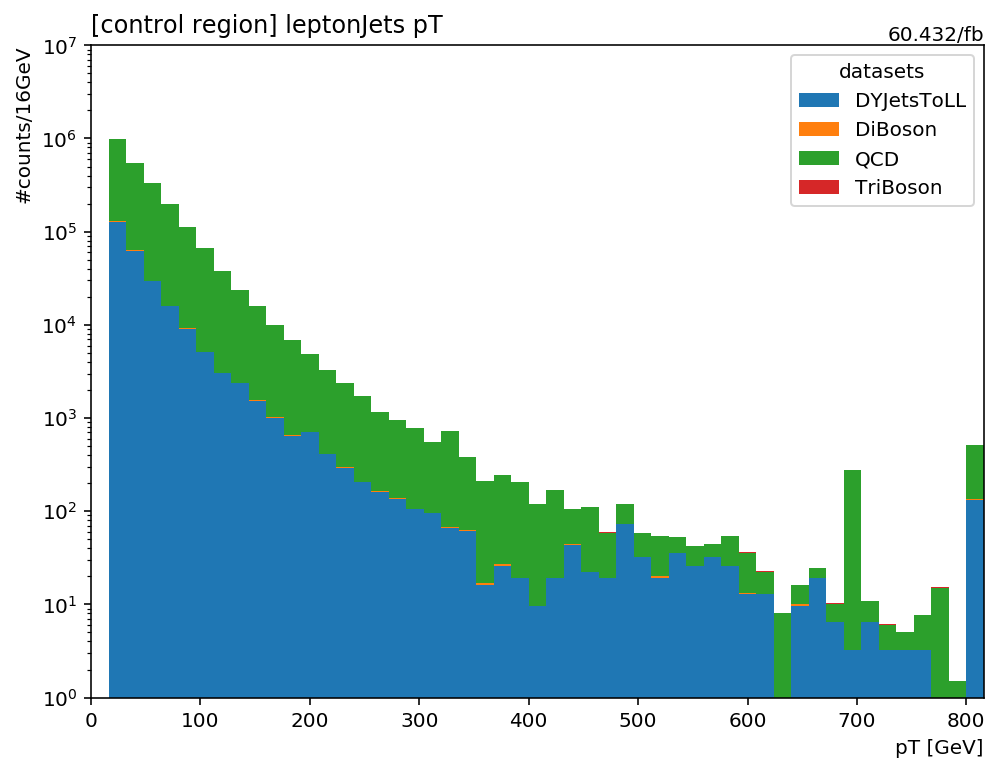

In [26]:
fig, ax = plt.subplots(figsize=(8,6))
fig, ax, _ = hist.plot1d(output['pt_cat'], overlay='cat', stack=True, ax=ax, overflow='over')
ax.set_yscale('log')
ax.set_ylim([1, 1e7])
ax.text(1,1,'60.432/fb', ha='right', va='bottom', transform=ax.transAxes)
ax.set_title('[control region] leptonJets pT', x=0.0, ha="left")
ax.set_xlabel(ax.get_xlabel(), x=1.0, ha="right")
ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right");

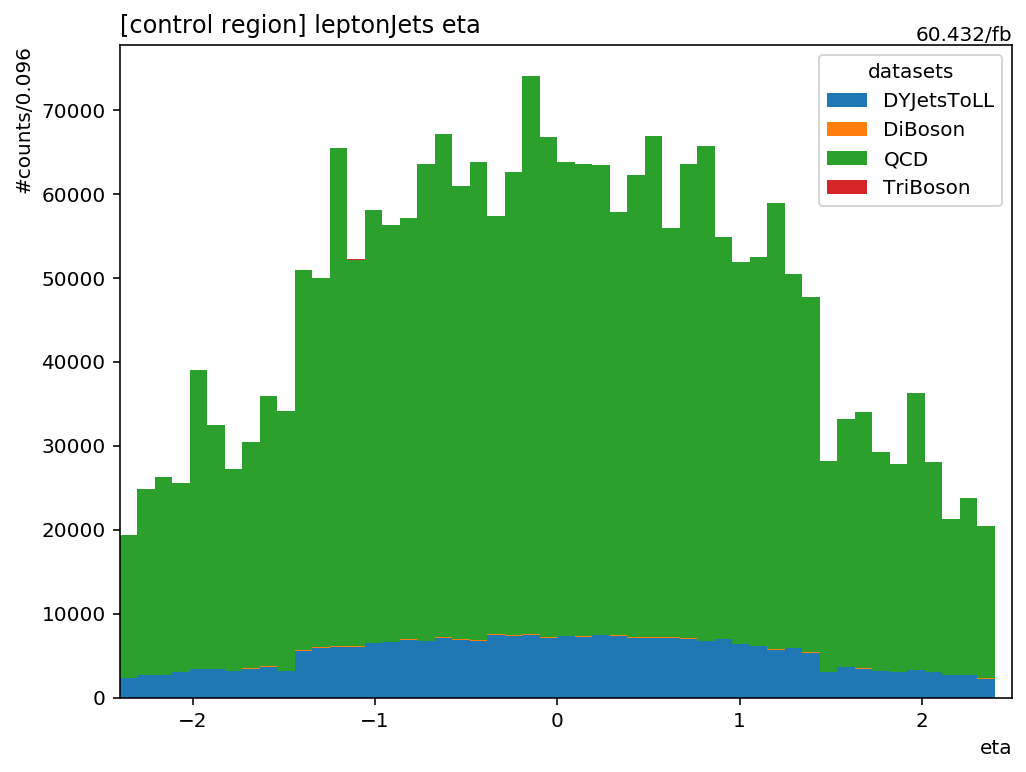

In [27]:
fig, ax = plt.subplots(figsize=(8,6))
fig, ax, _ = hist.plot1d(output['eta_cat'], overlay='cat', stack=True, ax=ax, overflow='over')

ax.text(1,1,'60.432/fb', ha='right', va='bottom', transform=ax.transAxes)
ax.set_title('[control region] leptonJets eta', x=0.0, ha="left")
ax.set_xlabel(ax.get_xlabel(), x=1.0, ha="right")
ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right");

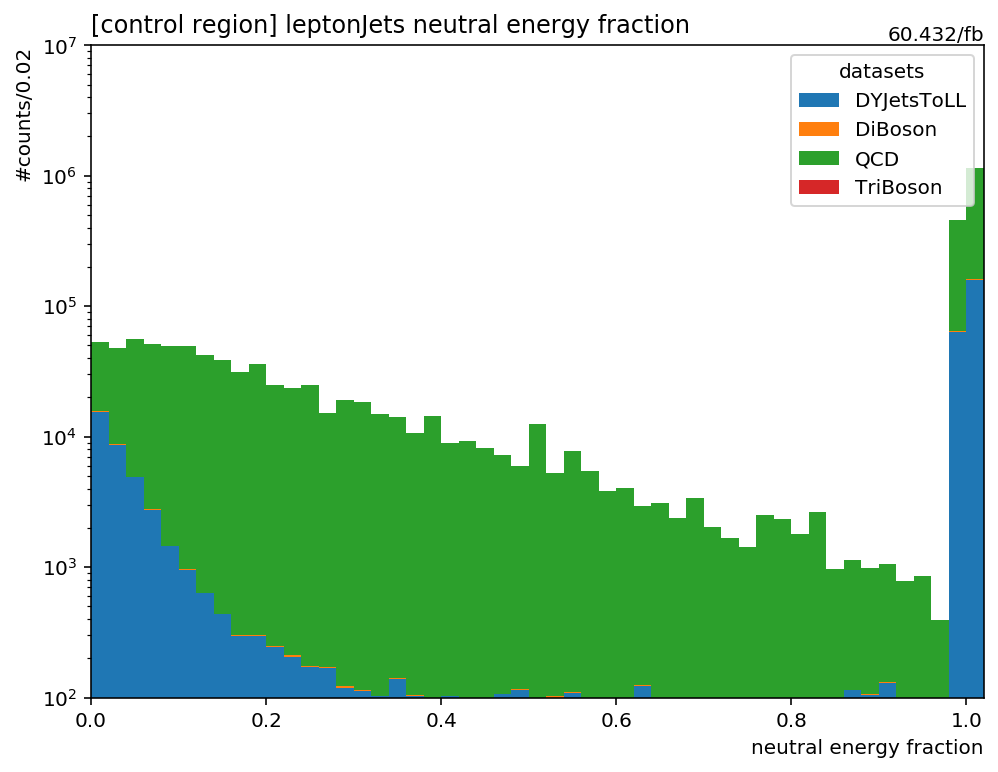

In [29]:
fig, ax = plt.subplots(figsize=(8,6))
fig, ax, _ = hist.plot1d(output['nef_cat'], overlay='cat', stack=True, ax=ax, overflow='over')
ax.set_yscale('log')
ax.set_ylim([1e2, 1e7])
ax.text(1,1,'60.432/fb', ha='right', va='bottom', transform=ax.transAxes)
ax.set_title('[control region] leptonJets neutral energy fraction', x=0.0, ha="left")
ax.set_xlabel(ax.get_xlabel(), x=1.0, ha="right")
ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right");

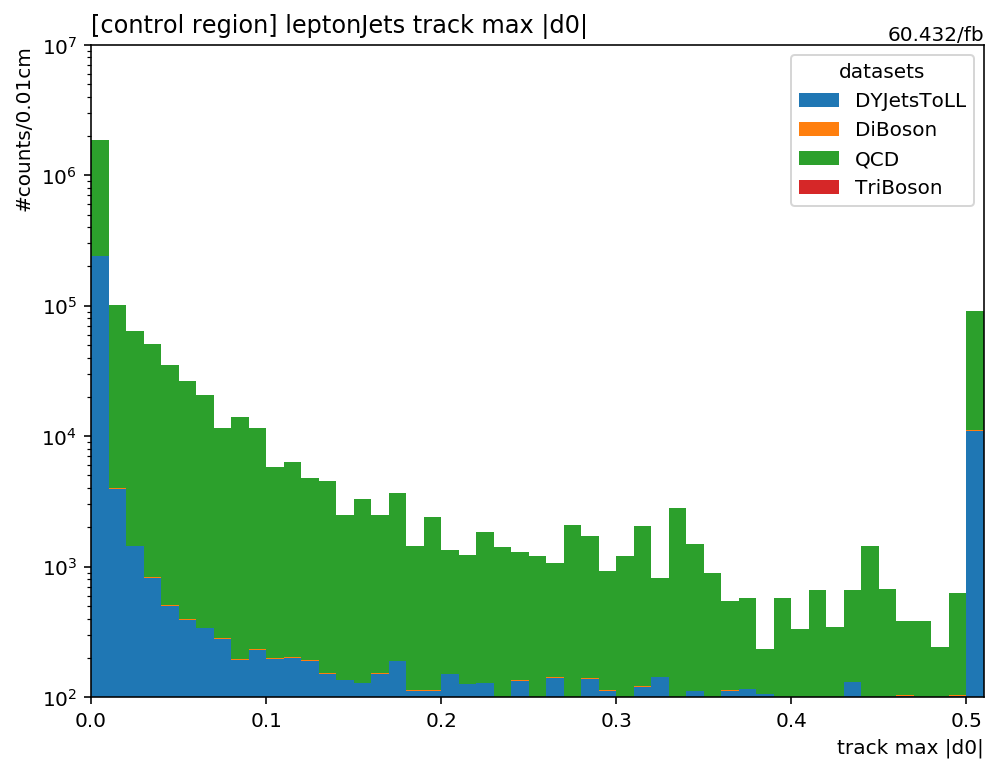

In [30]:
fig, ax = plt.subplots(figsize=(8,6))
fig, ax, _ = hist.plot1d(output['maxd0_cat'], overlay='cat', stack=True, ax=ax, overflow='over')
ax.set_yscale('log')
ax.set_ylim([1e2, 1e7])
ax.text(1,1,'60.432/fb', ha='right', va='bottom', transform=ax.transAxes)
ax.set_title('[control region] leptonJets track max |d0|', x=0.0, ha="left")
ax.set_xlabel(ax.get_xlabel(), x=1.0, ha="right")
ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right");

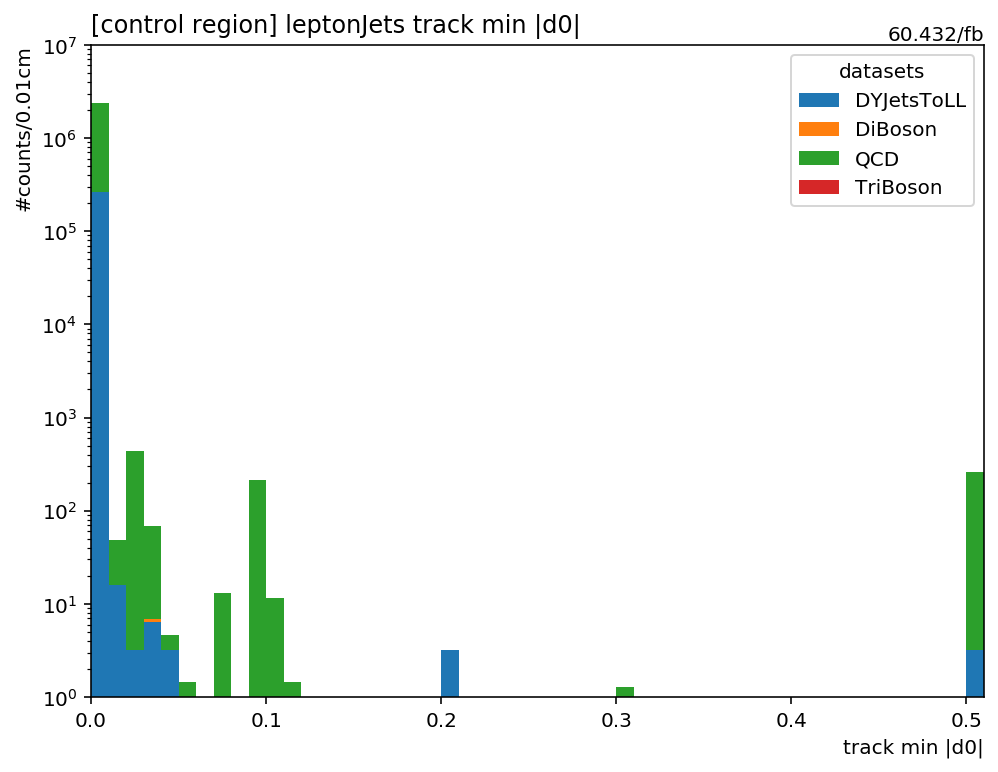

In [31]:
fig, ax = plt.subplots(figsize=(8,6))
fig, ax, _ = hist.plot1d(output['mind0_cat'], overlay='cat', stack=True, ax=ax, overflow='over')
ax.set_yscale('log')
ax.set_ylim([1, 1e7])
ax.text(1,1,'60.432/fb', ha='right', va='bottom', transform=ax.transAxes)
ax.set_title('[control region] leptonJets track min |d0|', x=0.0, ha="left")
ax.set_xlabel(ax.get_xlabel(), x=1.0, ha="right")
ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right");

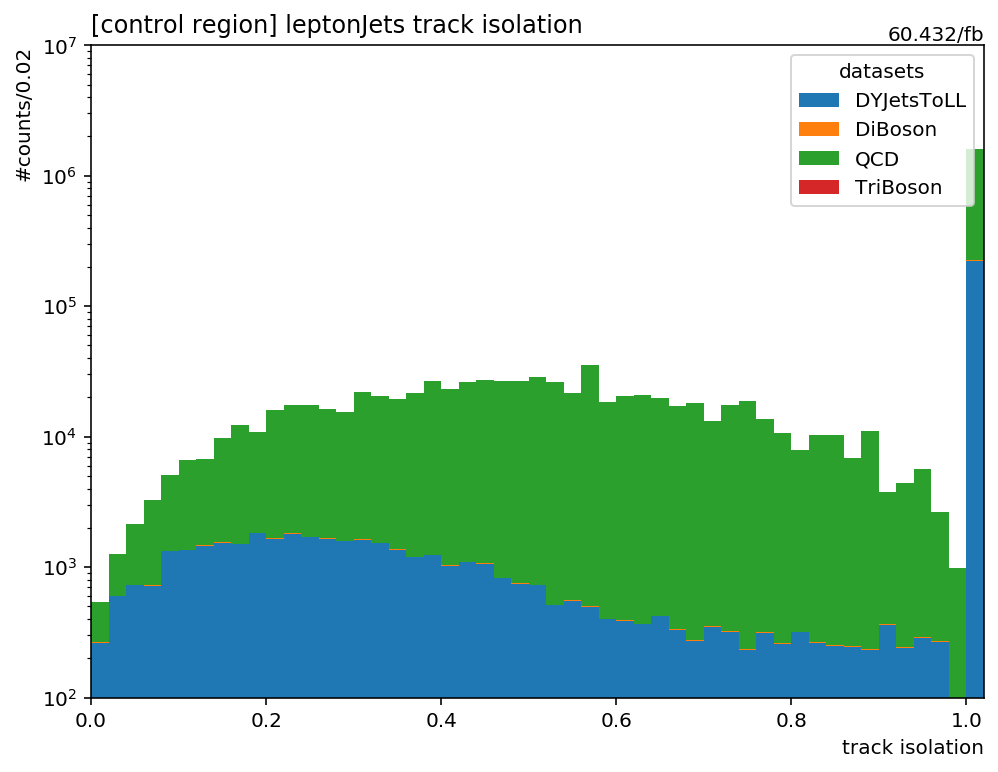

In [32]:
fig, ax = plt.subplots(figsize=(8,6))
fig, ax, _ = hist.plot1d(output['tkiso_cat'], overlay='cat', stack=True, ax=ax, overflow='over')
ax.set_yscale('log')
ax.set_ylim([1e2, 1e7])
ax.text(1,1,'60.432/fb', ha='right', va='bottom', transform=ax.transAxes)
ax.set_title('[control region] leptonJets track isolation', x=0.0, ha="left")
ax.set_xlabel(ax.get_xlabel(), x=1.0, ha="right")
ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right");

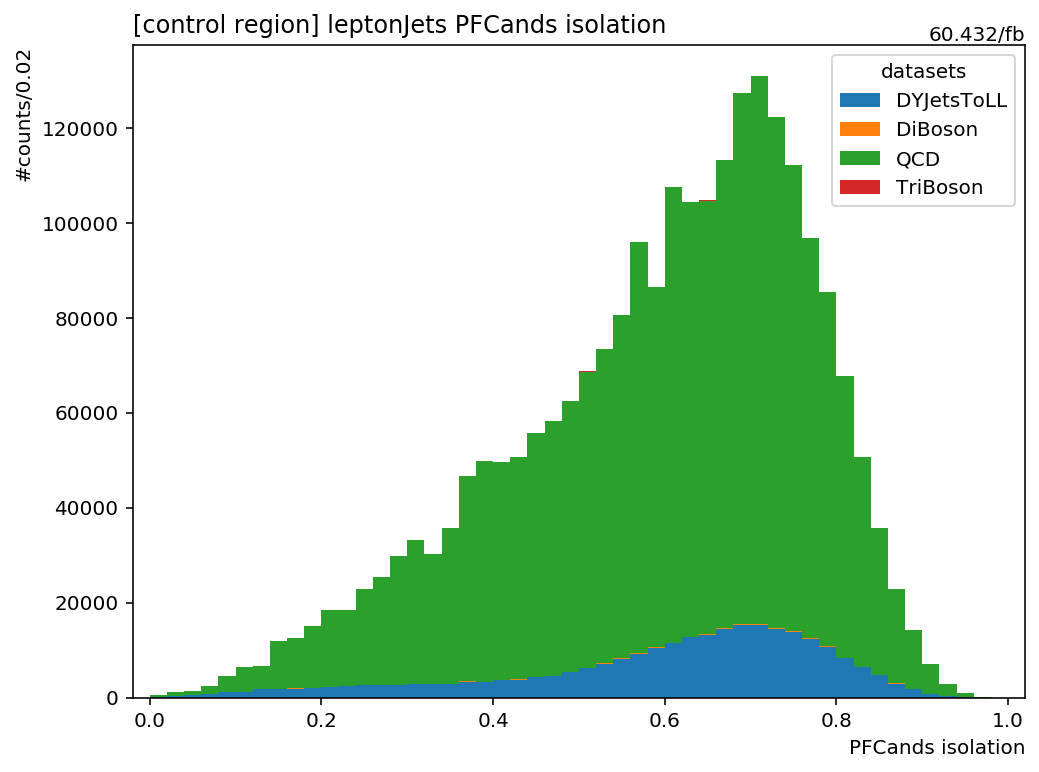

In [34]:
fig, ax = plt.subplots(figsize=(8,6))
fig, ax, _ = hist.plot1d(output['pfiso_cat'], overlay='cat', stack=True, ax=ax, overflow='all')

ax.text(1,1,'60.432/fb', ha='right', va='bottom', transform=ax.transAxes)
ax.set_title('[control region] leptonJets PFCands isolation', x=0.0, ha="left")
ax.set_xlabel(ax.get_xlabel(), x=1.0, ha="right")
ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right");

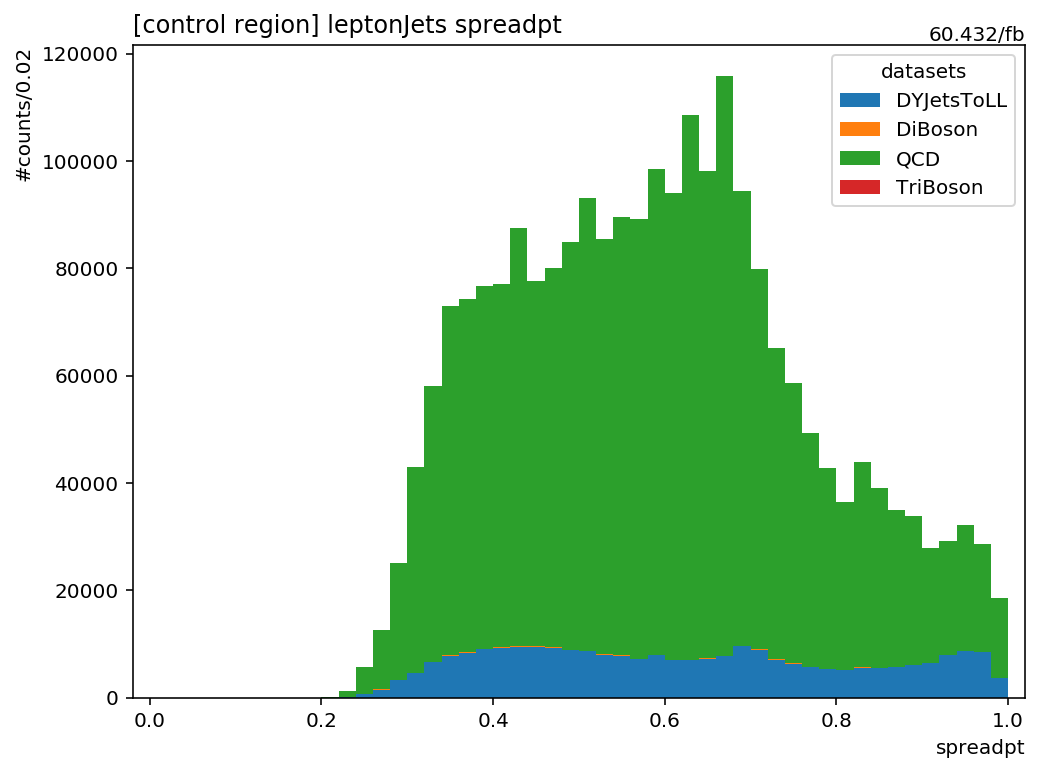

In [35]:
fig, ax = plt.subplots(figsize=(8,6))
fig, ax, _ = hist.plot1d(output['spreadpt_cat'], overlay='cat', stack=True, ax=ax, overflow='all')

ax.text(1,1,'60.432/fb', ha='right', va='bottom', transform=ax.transAxes)
ax.set_title('[control region] leptonJets spreadpt', x=0.0, ha="left")
ax.set_xlabel(ax.get_xlabel(), x=1.0, ha="right")
ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right");

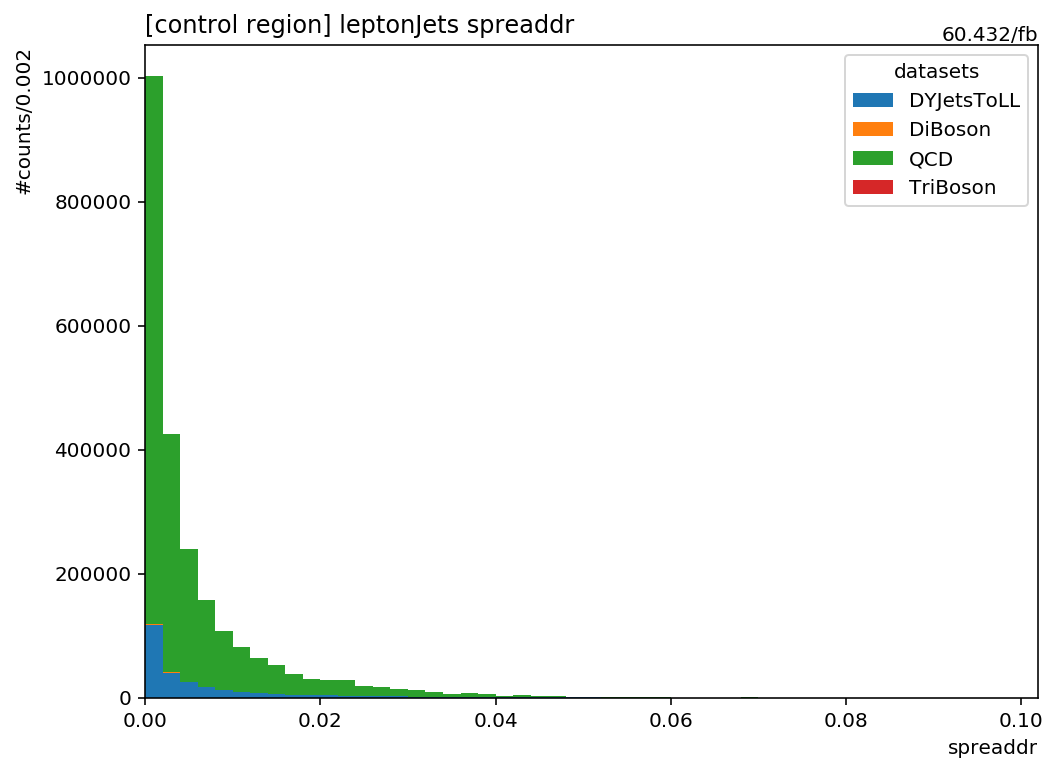

In [36]:
fig, ax = plt.subplots(figsize=(8,6))
fig, ax, _ = hist.plot1d(output['spreaddr_cat'], overlay='cat', stack=True, ax=ax, overflow='over')

ax.text(1,1,'60.432/fb', ha='right', va='bottom', transform=ax.transAxes)
ax.set_title('[control region] leptonJets spreaddr', x=0.0, ha="left")
ax.set_xlabel(ax.get_xlabel(), x=1.0, ha="right")
ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right");

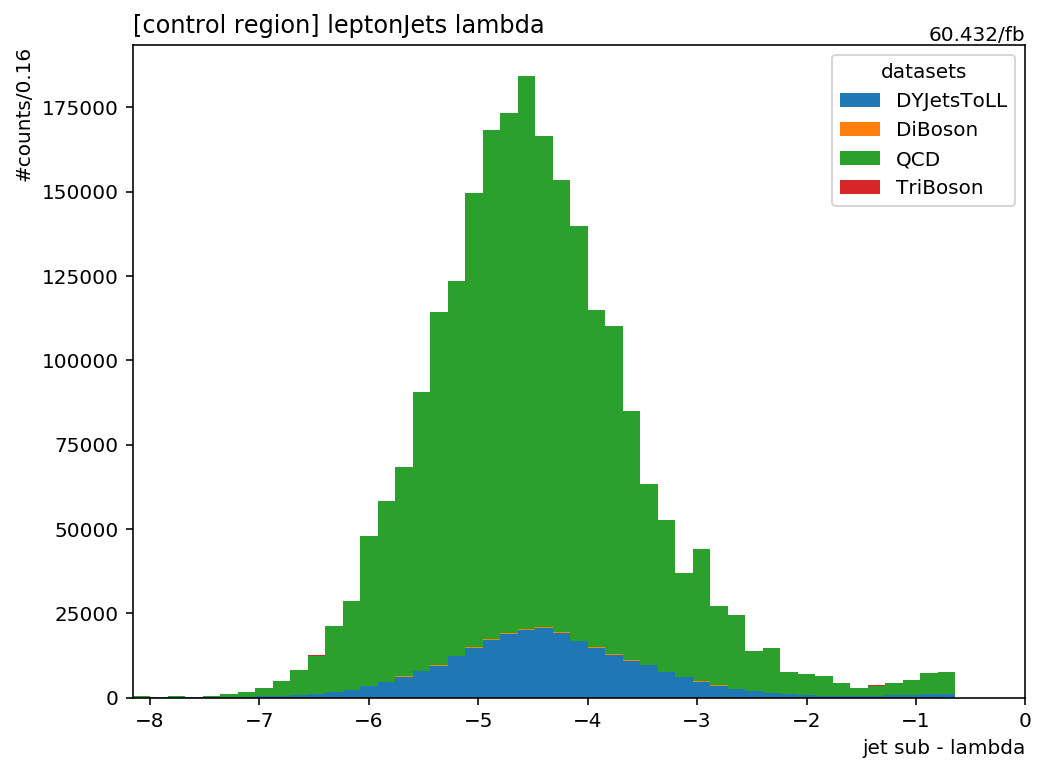

In [38]:
fig, ax = plt.subplots(figsize=(8,6))
fig, ax, _ = hist.plot1d(output['lamb_cat'], overlay='cat', stack=True, ax=ax, overflow='under')

ax.text(1,1,'60.432/fb', ha='right', va='bottom', transform=ax.transAxes)
ax.set_title('[control region] leptonJets lambda', x=0.0, ha="left")
ax.set_xlabel(ax.get_xlabel(), x=1.0, ha="right")
ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right");

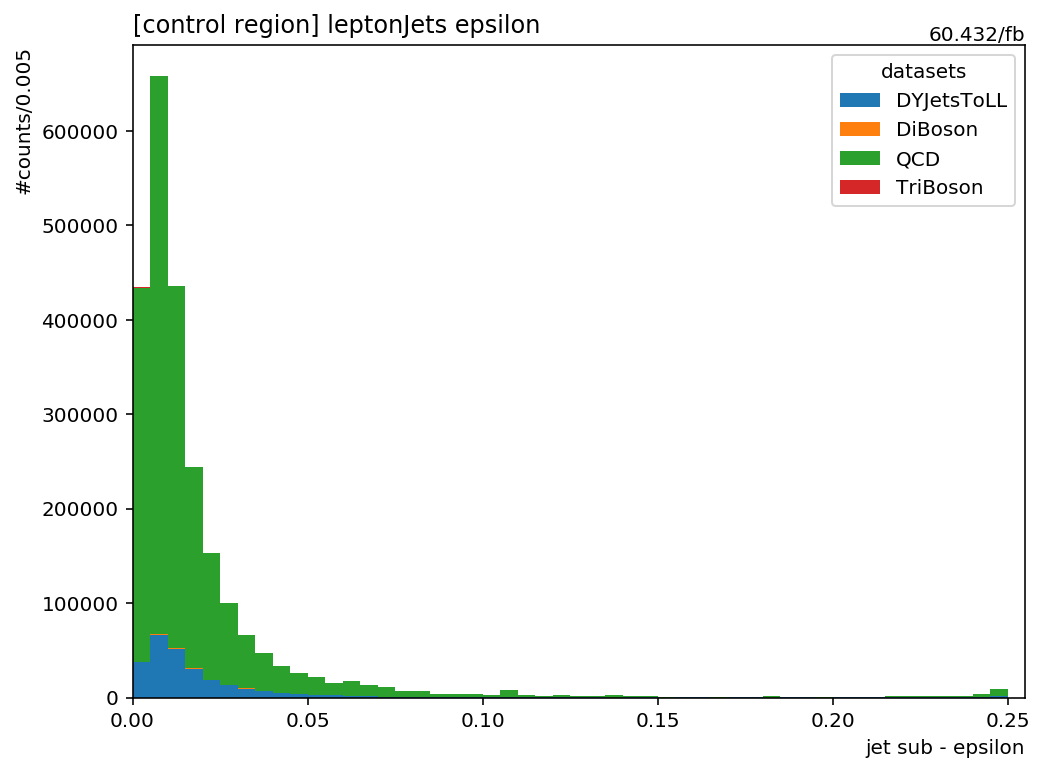

In [39]:
fig, ax = plt.subplots(figsize=(8,6))
fig, ax, _ = hist.plot1d(output['epsi_cat'], overlay='cat', stack=True, ax=ax, overflow='over')

ax.text(1,1,'60.432/fb', ha='right', va='bottom', transform=ax.transAxes)
ax.set_title('[control region] leptonJets epsilon', x=0.0, ha="left")
ax.set_xlabel(ax.get_xlabel(), x=1.0, ha="right")
ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right");

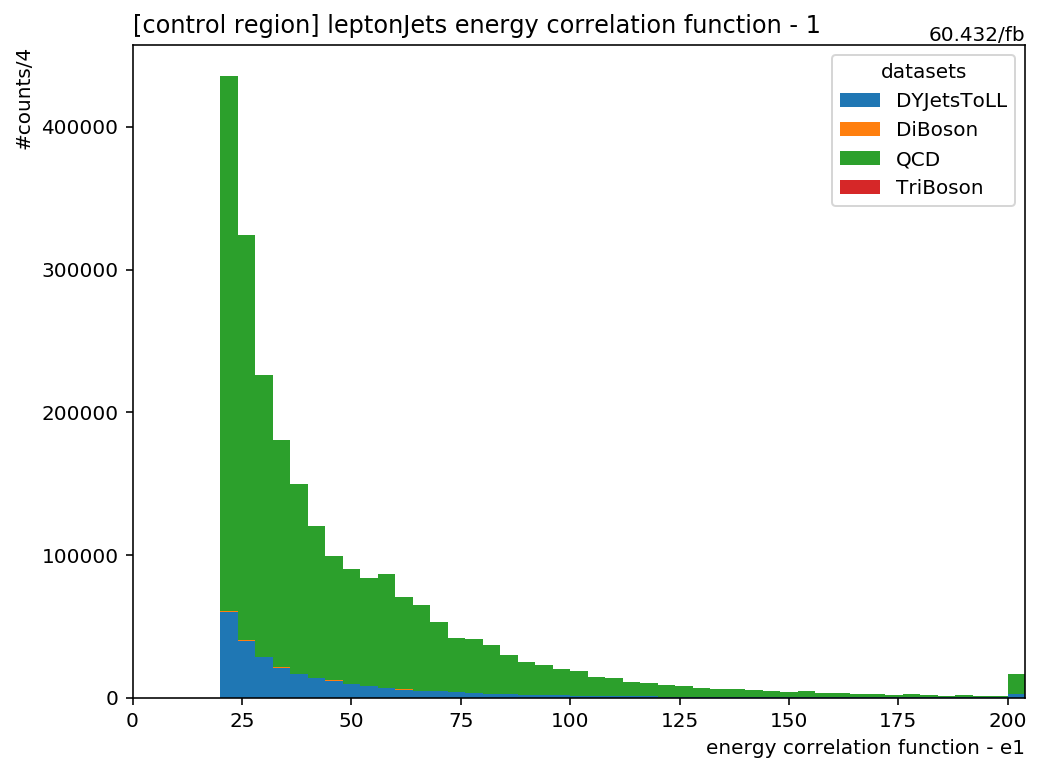

In [40]:
fig, ax = plt.subplots(figsize=(8,6))
fig, ax, _ = hist.plot1d(output['ecfe1_cat'], overlay='cat', stack=True, ax=ax, overflow='over')

ax.text(1,1,'60.432/fb', ha='right', va='bottom', transform=ax.transAxes)
ax.set_title('[control region] leptonJets energy correlation function - 1', x=0.0, ha="left")
ax.set_xlabel(ax.get_xlabel(), x=1.0, ha="right")
ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right");

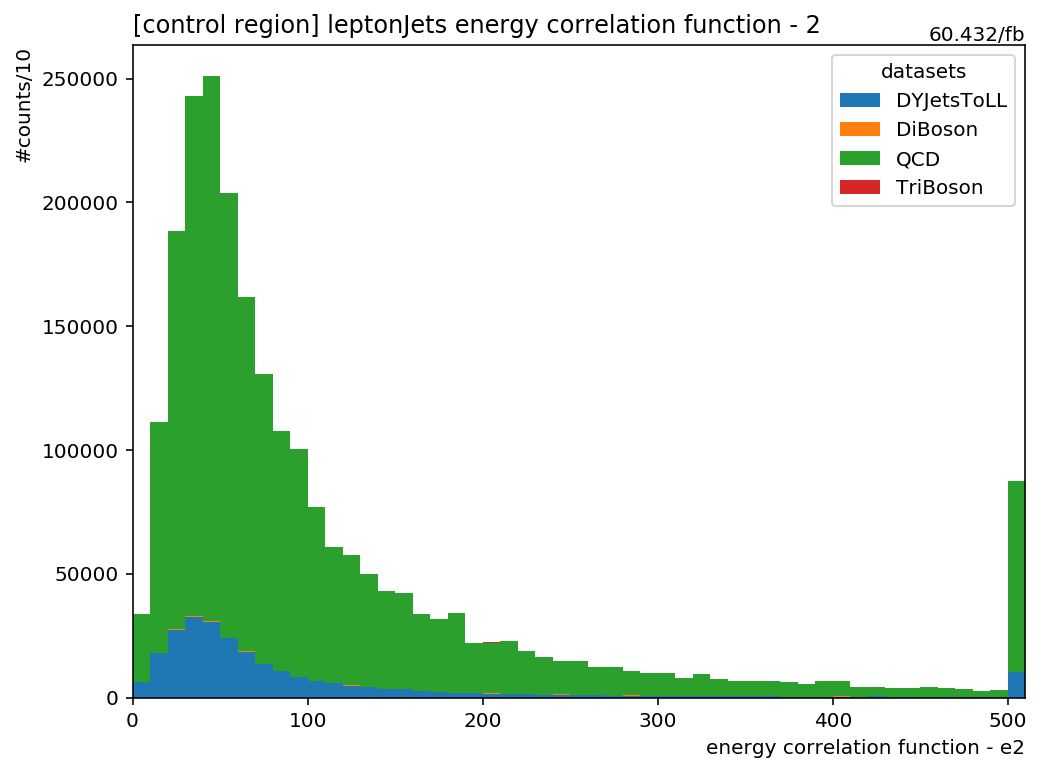

In [41]:
fig, ax = plt.subplots(figsize=(8,6))
fig, ax, _ = hist.plot1d(output['ecfe2_cat'], overlay='cat', stack=True, ax=ax, overflow='over')

ax.text(1,1,'60.432/fb', ha='right', va='bottom', transform=ax.transAxes)
ax.set_title('[control region] leptonJets energy correlation function - 2', x=0.0, ha="left")
ax.set_xlabel(ax.get_xlabel(), x=1.0, ha="right")
ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right");

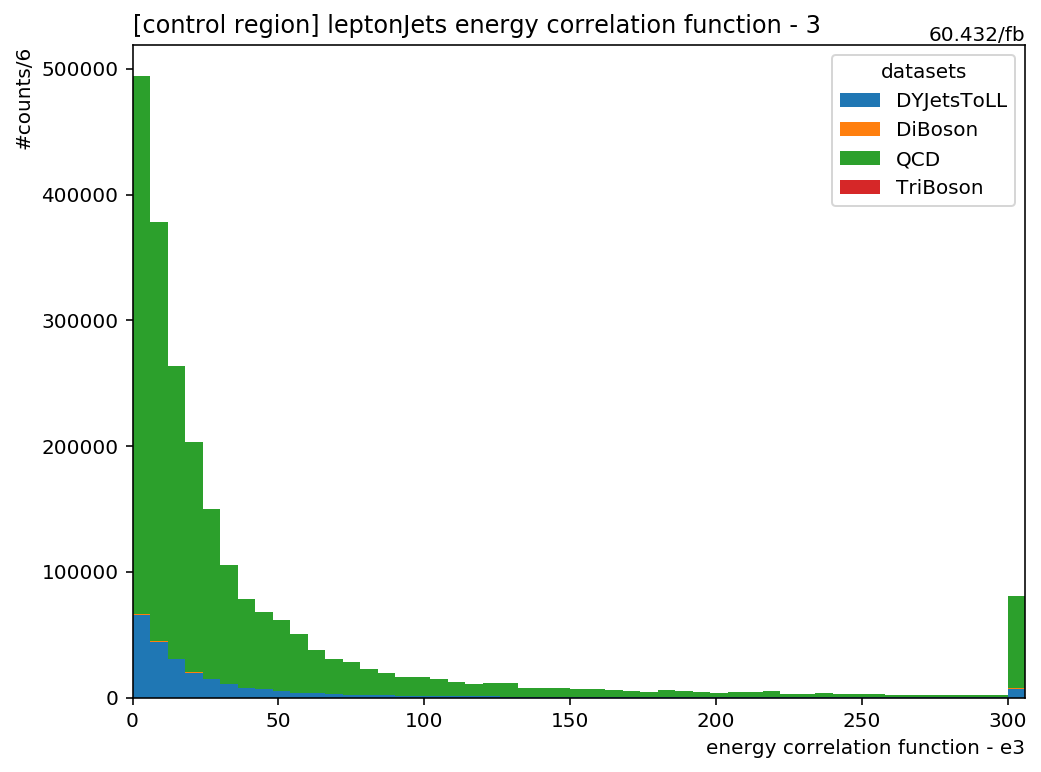

In [42]:
fig, ax = plt.subplots(figsize=(8,6))
fig, ax, _ = hist.plot1d(output['ecfe3_cat'], overlay='cat', stack=True, ax=ax, overflow='over')

ax.text(1,1,'60.432/fb', ha='right', va='bottom', transform=ax.transAxes)
ax.set_title('[control region] leptonJets energy correlation function - 3', x=0.0, ha="left")
ax.set_xlabel(ax.get_xlabel(), x=1.0, ha="right")
ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right");

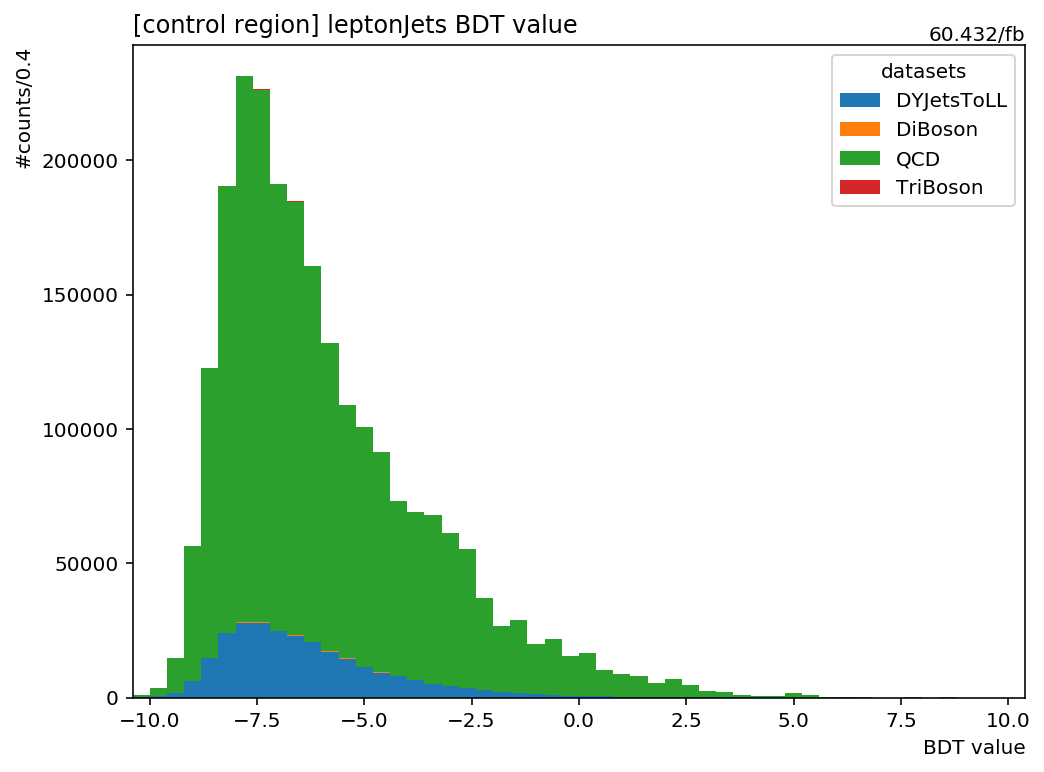

In [43]:
fig, ax = plt.subplots(figsize=(8,6))
fig, ax, _ = hist.plot1d(output['mva_cat'], overlay='cat', stack=True, ax=ax, overflow='all')

ax.text(1,1,'60.432/fb', ha='right', va='bottom', transform=ax.transAxes)
ax.set_title('[control region] leptonJets BDT value', x=0.0, ha="left")
ax.set_xlabel(ax.get_xlabel(), x=1.0, ha="right")
ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right");

### leptonJet pair
- invariant mass
- delta phi

In [46]:
class LeptonJetPairProcessor(processor.ProcessorABC):
    def __init__(self):
        dataset_axis = hist.Cat('dataset', 'Control region')
        mass_axis = hist.Bin("mass", "invM [GeV]", 50, 0, 500)
        dphi_axis = hist.Bin('dphi', "$\Delta\Phi$", 50, 0, 3.142)
        
        self._accumulator = processor.dict_accumulator({
            'mass': hist.Hist("#counts/10GeV", dataset_axis, mass_axis),
            'dphi': hist.Hist("#counts/$\pi$/50", dataset_axis, dphi_axis),
        })
    
    @property
    def accumulator(self):
        return self._accumulator
    
    def process(self, df):
        output = self.accumulator.identity()
        
        dataset = df['dataset']
        leptonjets = JaggedCandidateArray.candidatesfromcounts(
            df['pfjet_p4'],
            px=df['pfjet_p4.fCoordinates.fX'],
            py=df['pfjet_p4.fCoordinates.fY'],
            pz=df['pfjet_p4.fCoordinates.fZ'],
            energy=df['pfjet_p4.fCoordinates.fT'],
        )
        
        twoleptonjets = leptonjets.counts>=2
        dileptonjets = leptonjets[twoleptonjets]
        leptonjetpair = dileptonjets.distincts()
        sumpt = leptonjetpair.i0.pt+leptonjetpair.i1.pt
        if sumpt.size!=0:
            leadingLjPair = leptonjetpair[sumpt.argmax()]
            controlregion = np.abs(leadingLjPair.i0.p4.delta_phi(leadingLjPair.i1.p4))<2.5
            leadingLjPair_ = leadingLjPair[controlregion]
            dphi_ = np.abs(leadingLjPair_.i0.p4.delta_phi(leadingLjPair_.i1.p4))
            
            output['mass'].fill(dataset=dataset, mass=leadingLjPair_.mass.flatten())
            output['dphi'].fill(dataset=dataset, dphi=dphi_.flatten())
        
        return output
    
    def postprocess(self, accumulator):
        origidentity = list(accumulator)
        # scale
        for k in origidentity:
            accumulator[k].scale(scales, axis='dataset')
        # cat grouping
            accumulator[k+'_cat'] = accumulator[k].group(hist.Cat("cat", "datasets"), "dataset", mapping)
        return accumulator

In [47]:
output = processor.run_uproot_job(datasets,
                                  treename=None,
                                  processor_instance=LeptonJetPairProcessor(),
                                  executor=processor.futures_executor,
                                  executor_args=dict(workers=12, flatten=True),
                                  chunksize=500000,
                                 )

Processing: 100%|██████████| 2753/2753 [01:58<00:00, 17.39items/s]


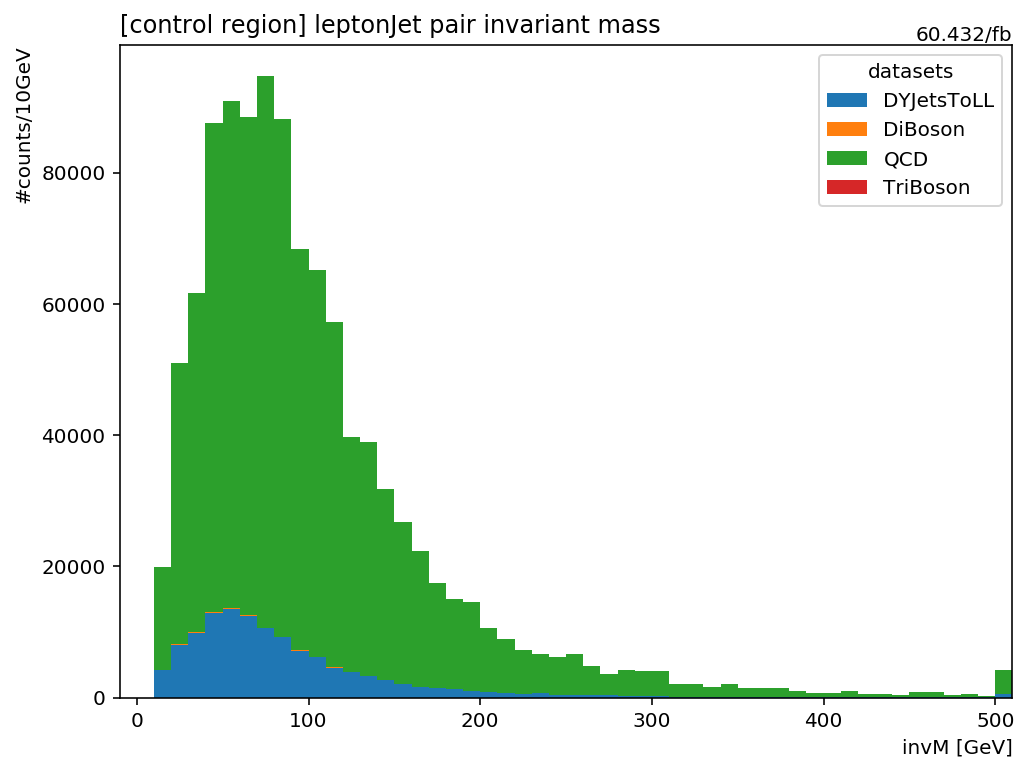

In [48]:
fig, ax = plt.subplots(figsize=(8,6))
fig, ax, _ = hist.plot1d(output['mass_cat'], overlay='cat', stack=True, ax=ax, overflow='over')

ax.text(1,1,'60.432/fb', ha='right', va='bottom', transform=ax.transAxes)
ax.set_title('[control region] leptonJet pair invariant mass', x=0.0, ha="left")
ax.set_xlabel(ax.get_xlabel(), x=1.0, ha="right")
ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right");

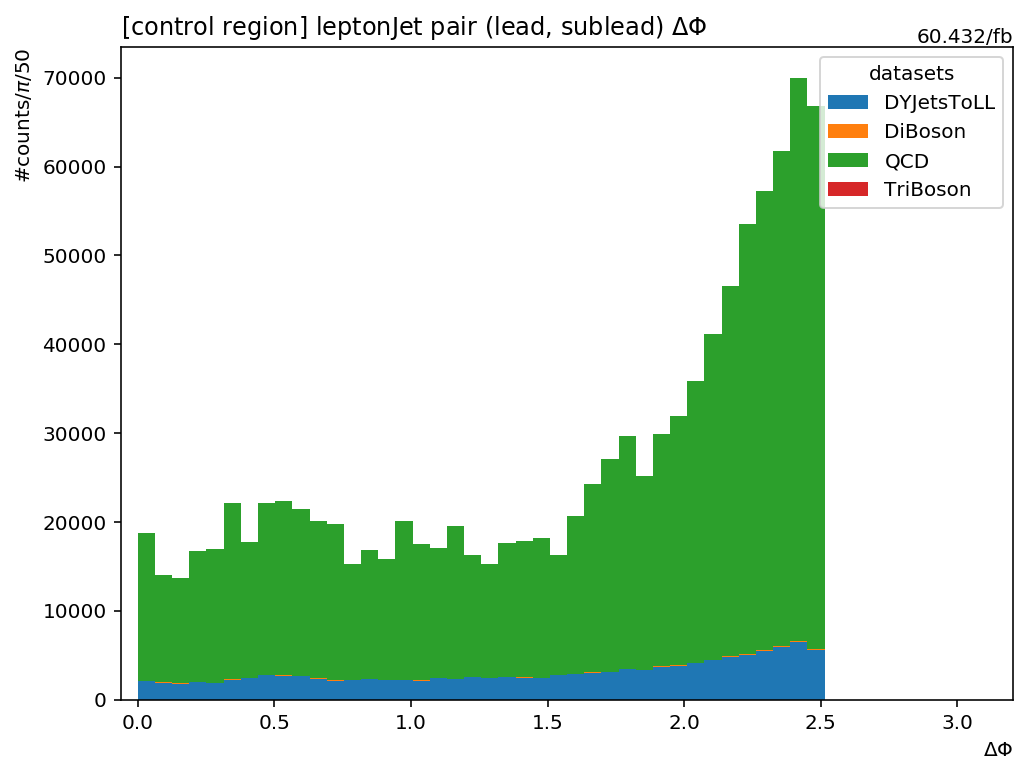

In [49]:
fig, ax = plt.subplots(figsize=(8,6))
fig, ax, _ = hist.plot1d(output['dphi_cat'], overlay='cat', stack=True, ax=ax, overflow='all')

ax.text(1,1,'60.432/fb', ha='right', va='bottom', transform=ax.transAxes)
ax.set_title('[control region] leptonJet pair (lead, sublead) $\Delta\Phi$', x=0.0, ha="left")
ax.set_xlabel(ax.get_xlabel(), x=1.0, ha="right")
ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right");

---